# Yale Colon TMA Spatial Transcriptomics Analysis

This notebook analyzes spatial transcriptomics data from Yale's Colon Tissue Microarray (TMA) dataset.

## Data Overview
The dataset contains:
- `Colon_TMA_exprMat_file.csv.gz`: Gene expression matrix
- `Colon_TMA_fov_positions_file.csv.gz`: Field of view positions
- `Colon_TMA_metadata_file.csv.gz`: Sample metadata
- `Colon_TMA_tx_file.csv.gz`: Transcript information
- `Colon_TMA-polygons.csv.gz`: Spatial polygon coordinates

## Analysis Pipeline
1. Data loading and exploration
2. Quality control and preprocessing
3. Spatial analysis
4. Gene expression analysis
5. Visualization


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

# Set scanpy settings
sc.settings.verbosity = 3  # verbosity level

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Loading and Exploration


In [3]:
# Load the data files
print("Loading data files...")

# Load expression matrix
expr_mat = pd.read_csv('Colon_TMA_exprMat_file.csv.gz', compression='gzip', index_col=0)
print(f"Expression matrix shape: {expr_mat.shape}")

# Load FOV positions
fov_positions = pd.read_csv('Colon_TMA_fov_positions_file.csv.gz', compression='gzip')
print(f"FOV positions shape: {fov_positions.shape}")

# Load metadata
metadata = pd.read_csv('Colon_TMA_metadata_file.csv.gz', compression='gzip')
print(f"Metadata shape: {metadata.shape}")


# Load transcript file
tx_file = pd.read_csv('Colon_TMA_tx_file.csv.gz', compression='gzip')
print(f"Transcript file shape: {tx_file.shape}")

# Load polygons
polygons = pd.read_csv('Colon_TMA-polygons.csv.gz', compression='gzip')
print(f"Polygons shape: {polygons.shape}")

print("\nData loading completed!")


Loading data files...
Expression matrix shape: (447722, 19245)
FOV positions shape: (361, 5)
Metadata shape: (447722, 98)
Transcript file shape: (246922812, 10)
Polygons shape: (8711087, 7)

Data loading completed!


In [4]:
# Explore the data structure
print("=== EXPRESSION MATRIX ===")
print(f"Shape: {expr_mat.shape}")
print(f"Index (spots/cells): {expr_mat.index[:5].tolist()}...")
print(f"Columns (genes): {expr_mat.columns[:5].tolist()}...")
print(f"Data type: {expr_mat.dtypes.iloc[0]}")
print(f"Memory usage: {expr_mat.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== FOV POSITIONS ===")
print(fov_positions.head())
print(f"\nColumns: {fov_positions.columns.tolist()}")

print("\n=== METADATA ===")
print(metadata.head())
print(f"\nColumns: {metadata.columns.tolist()}")

print("\n=== TRANSCRIPT FILE ===")
print(tx_file.head())
print(f"\nColumns: {tx_file.columns.tolist()}")

print("\n=== POLYGONS ===")
print(polygons.head())
print(f"\nColumns: {polygons.columns.tolist()}")


=== EXPRESSION MATRIX ===
Shape: (447722, 19245)
Index (spots/cells): [1, 1, 1, 1, 1]...
Columns (genes): ['cell_ID', 'A1BG', 'A1CF', 'A2M', 'A2ML1']...
Data type: int64
Memory usage: 65741.41 MB

=== FOV POSITIONS ===
   FOV  x_global_px  y_global_px  x_global_mm  y_global_mm
0    1         6323       163445     0.760560    19.659262
1    2        13235       163061     1.591942    19.613084
2    3        19763       162293     2.377136    19.520728
3    4        25139       162101     3.023766    19.497639
4    5        31027       162101     3.731980    19.497639

Columns: ['FOV', 'x_global_px', 'y_global_px', 'x_global_mm', 'y_global_mm']

=== METADATA ===
  RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters  \
0                                                  e      
1                                                  d      
2                                                  f      
3                                                  h      
4                                   

In [27]:
# print first 5 rows of all dataframes
print("\nFirst 5 rows of Expression Matrix:")
print(expr_mat.head())
print("\nFirst 5 rows of FOV Positions:")
print(fov_positions.head())
print("\nFirst 5 rows of Metadata:")
print(metadata.head())
print("\nFirst 5 rows of Transcript File:")
print(tx_file.head())
print("\nFirst 5 rows of Polygons:")
print(polygons.head())


First 5 rows of Expression Matrix:
     cell_ID  A1BG  A1CF  A2M  A2ML1  A3GALT2  A4GALT  A4GNT  AAAS  AACS  ...  \
fov                                                                       ...   
1          1     0     0    0      0        0       0      0     0     0  ...   
1          2     0     0    0      0        0       0      0     0     0  ...   
1          3     0     0    0      0        0       0      0     0     0  ...   
1          4     0     0    0      0        0       0      0     0     0  ...   
1          5     0     0    0      0        0       0      0     0     0  ...   

     ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3  
fov                                                                     
1         0      0     0     0     0       0       0    0      0     0  
1         0      0     0     0     2       0       0    0      1     0  
1         0      0     0     0     0       0       0    0      0     0  
1         0      0     0     0 

## Creating Andata Object

In [31]:
expr = expr_mat.reset_index() # reset index to make fov a column
# unique mapping between (fov, cell_ID) and "cell" label such as c_1_1_1
cell_map = (
    tx_file[["fov", "cell_ID", "cell"]]
    .drop_duplicates()
)

print(cell_map.head())
print(f"Mapping rows: {len(cell_map)}")


       fov  cell_ID     cell
0        1        0  c_1_1_0
78521    1        1  c_1_1_1
78839    1        2  c_1_1_2
84893    1        3  c_1_1_3
85136    1        4  c_1_1_4
Mapping rows: 448083


In [43]:
# Merge to add "cell" column to each row of expr_mat
expr_with_cell = expr_mat.merge(
    cell_map,
    on=["fov", "cell_ID"],
    how="left",
    validate="one_to_one"  # will raise if inconsistent
)

# Sanity check
print(expr_with_cell[["fov", "cell_ID", "cell"]].head())
missing_cells = expr_with_cell["cell"].isna().sum()
print("Rows without a cell label:", missing_cells)

   fov  cell_ID     cell
0    1        1  c_1_1_1
1    1        2  c_1_1_2
2    1        3  c_1_1_3
3    1        4  c_1_1_4
4    1        5  c_1_1_5
Rows without a cell label: 0


In [44]:
non_gene_cols = ["fov", "cell_ID", "cell"]
gene_cols = [c for c in expr_with_cell.columns if c not in non_gene_cols]

print("Number of genes:", len(gene_cols))
print("First 5 genes:", gene_cols[:5])

Number of genes: 19244
First 5 genes: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']


In [48]:
# Convert to sparse to reduce RAM
X = sparse.csr_matrix((expr_with_cell[gene_cols].astype("uint16")).values)

print("Sparse X shape:", X.shape)

Sparse X shape: (447722, 19244)


In [49]:
# Basic obs with cell IDs and fov
expr_with_cell = expr_with_cell[["cell", "fov"]].copy()
obs = expr_with_cell[["cell", "fov"]].copy()
obs.index = obs["cell"].astype(str)
obs = obs.drop(columns=["cell"])

print(obs.head())


         fov
cell        
c_1_1_1    1
c_1_1_2    1
c_1_1_3    1
c_1_1_4    1
c_1_1_5    1


In [51]:
meta = metadata.copy()
meta.index = meta["cell"].astype(str)

# Columns in meta that also exist in obs
overlap = [c for c in meta.columns if c in obs.columns]
print("Overlapping columns:", overlap)

# Drop them (EXCEPT 'cell', which we already drop later)
meta = meta.drop(columns=overlap)

# Now join safely
obs = obs.join(meta, how="left")

print(obs.head())
print("obs shape:", obs.shape)

Overlapping columns: ['fov']
         fov RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters  \
cell                                                                 
c_1_1_1    1                                                  e      
c_1_1_2    1                                                  d      
c_1_1_3    1                                                  f      
c_1_1_4    1                                                  h      
c_1_1_5    1                                                  d      

         RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_posterior_probability  \
cell                                                                          
c_1_1_1                                           0.667105                    
c_1_1_2                                           1.000000                    
c_1_1_3                                           0.999637                    
c_1_1_4                                           0.998237                    
c_1_1_

In [52]:
var = pd.DataFrame(index=gene_cols)
var.index.name = "gene_id"
print(var.head())


Empty DataFrame
Columns: []
Index: [A1BG, A1CF, A2M, A2ML1, A3GALT2]


In [53]:
adata = ad.AnnData(X=X, obs=obs, var=var)
print(adata)

AnnData object with n_obs × n_vars = 447722 × 19244
    obs: 'fov', 'RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters', 'RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_posterior_probability', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.G', 'Max.G', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'SplitRatioToLocal', 'NucArea', 'NucAspectRatio', 'Circularity', 'Eccentricity', 'Perimeter', 'Solidity', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_qua

In [ ]:
# save adata object
adata.write('colon_adata.h5ad')

## Data Exploration and Preprocessing

In [71]:
# Adding spatial coordinates to AnnData object
coord_cols = ["CenterX_local_px", "CenterY_local_px"]
adata.obsm["spatial"] = adata.obs[coord_cols].values
# store the fov level global positions
adata.uns["fov_positions"] = fov_positions
# adding polygons
adata.uns["polygons"] = polygons

In [75]:
# store high level data info
adata.uns["dataset_info"] = {
    "expression_matrix_n_cells": X.shape[0],
    "expression_matrix_n_genes": X.shape[1],
    "n_metadata_columns": obs.shape[1],
    "n_polygon_vertices": len(polygons),
    "n_transcript_rows": len(tx_file), 
    "source_files": {
        "expr_mat": "Colon_TMA_exprMat_file.csv.gz",
        "metadata": "Colon_TMA_metadata_file.csv.gz",
        "tx_file": "Colon_TMA_tx_file.csv.gz",
        "polygons": "Colon_TMA-polygons.csv.gz",
        "fov_positions": "Colon_TMA_fov_positions_file.csv.gz"
    }
}

In [80]:
print(adata)

AnnData object with n_obs × n_vars = 447722 × 19244
    obs: 'fov', 'RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters', 'RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_posterior_probability', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.G', 'Max.G', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'SplitRatioToLocal', 'NucArea', 'NucAspectRatio', 'Circularity', 'Eccentricity', 'Perimeter', 'Solidity', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_qua

### Initial Visualizations

In [90]:
# Basic fov filter
fov_id = 1   # choose FOV to plot

adata_fov = adata[adata.obs["fov"] == fov_id].copy()

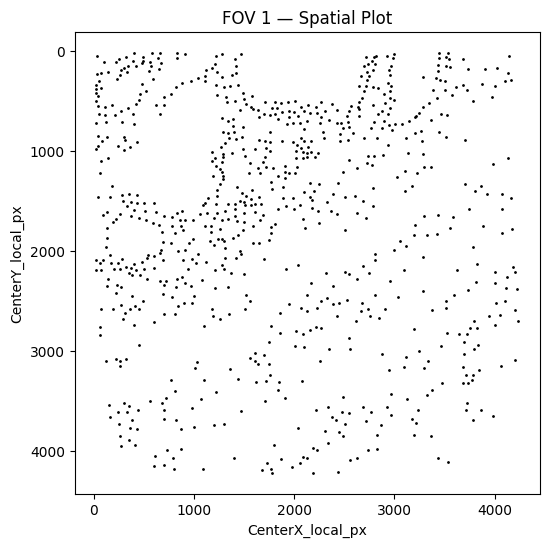

In [91]:
fig, ax = plt.subplots(figsize=(6, 6))

x = adata_fov.obsm["spatial"][:, 0]
y = adata_fov.obsm["spatial"][:, 1]

ax.scatter(x, y, s=1, c="black")
ax.set_title(f"FOV {fov_id} — Spatial Plot")
ax.set_xlabel("CenterX_local_px")
ax.set_ylabel("CenterY_local_px")
ax.invert_yaxis()  # important for image coordinates

plt.show()

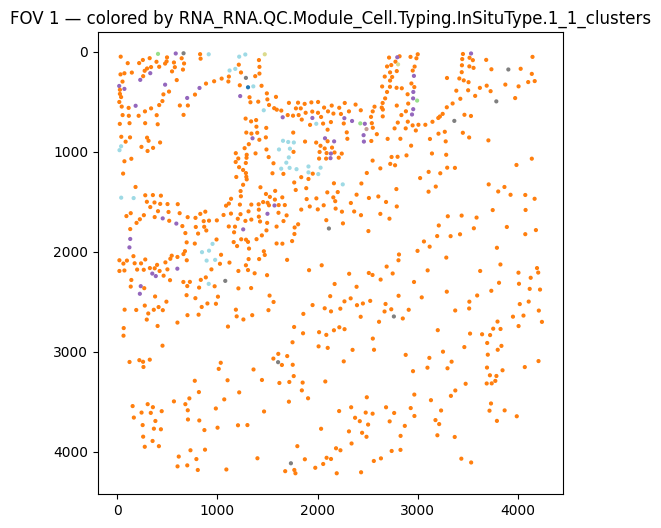

In [92]:
# Plot fov_id colored by a specific cluster column
cluster_col = "RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    x,
    y,
    s=4,
    c=adata_fov.obs[cluster_col].astype("category").cat.codes,
    cmap="tab20",
)

ax.set_title(f"FOV {fov_id} — colored by {cluster_col}")
ax.invert_yaxis()
plt.show()

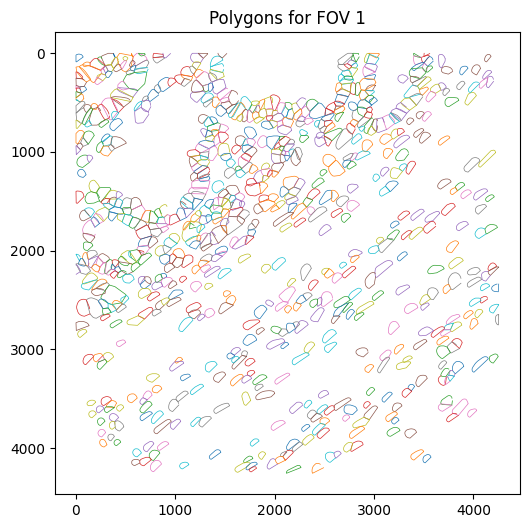

In [93]:
poly = adata.uns["polygons"]

fov_id = 1
poly_fov = poly[poly["fov"] == fov_id]

fig, ax = plt.subplots(figsize=(6, 6))

for cell, df in poly_fov.groupby("cell"):
    ax.plot(df["x_local_px"], df["y_local_px"], linewidth=0.5)

ax.set_title(f"Polygons for FOV {fov_id}")
ax.invert_yaxis()
plt.show()

In [87]:
# compute centroids from transcript file
cell_global = (
    tx_file.groupby("cell")[["x_global_px", "y_global_px"]]
    .median()
)

# align with adata
cell_global = cell_global.reindex(adata.obs_names)

adata.obsm["spatial_global"] = cell_global.values

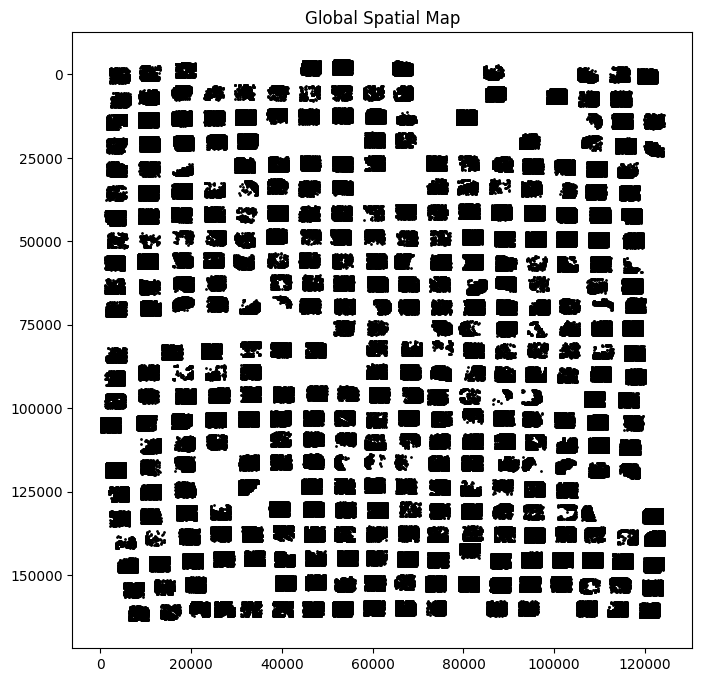

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))

coords = adata.obsm["spatial_global"]
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="black")
ax.set_title("Global Spatial Map")
ax.invert_yaxis()

plt.show()